<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/XGBoost(singlevar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from math import sqrt
from numpy import concatenate
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
import xgboost as xgb

# Data Process

In [4]:
### Import data & dropna
df = pd.read_excel('d1.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])
df

,Date,NOx
0,2015-01-01 00:15:00,62.2314
1,2015-01-01 00:30:00,75.7350
2,2015-01-01 00:45:00,70.4414
5,2015-01-01 01:30:00,29.6205
6,2015-01-01 01:45:00,53.4148
...,...,...
210426,2020-12-31 22:45:00,11.7719
210427,2020-12-31 23:00:00,25.4470
210428,2020-12-31 23:15:00,34.3861
210429,2020-12-31 23:30:00,47.5379


In [5]:
### Data selection(date & NOx)
data = df[df.Date < '20151231']
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

data.shape

(34176,)

In [6]:
### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)

avg.shape

(8544,)

In [7]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
avg = avg.reshape(len(avg), 1)
data = scaler.fit_transform(avg)
# data = data.reshape(len(data),)

data

array([[0.05503139],
       [0.02979788],
       [0.02462762],
       ...,
       [0.06782278],
       [0.05317554],
       [0.03526155]])

# Build dataset

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_mins = 5
n_features = 1
reframed = series_to_supervised(data, n_mins, 1)
reframed.shape

(8539, 6)

In [9]:
# split into train and test sets
values = reframed.values
n_val = 36
train = values[:-n_val, :]
test = values[-n_val:, :]
# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y =test[:, :n_obs], test[:,-1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8503, 5) (8503,) (36, 5) (36,)


# XGBoost

In [10]:
# design XGBoost model
clf = xgb.XGBRegressor(learning_rate = 0.01, n_estimators=900, max_depth=8, min_child_weight=7, seed=0,
                subsample=0.2, colsample_bytree=0.9, gamma=0.01, reg_alpha=7, reg_lambda=4)
# fit model
clf.fit(train_X,train_y)
# make a prediction
predict_y = clf.predict(test_X)
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))

[08:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

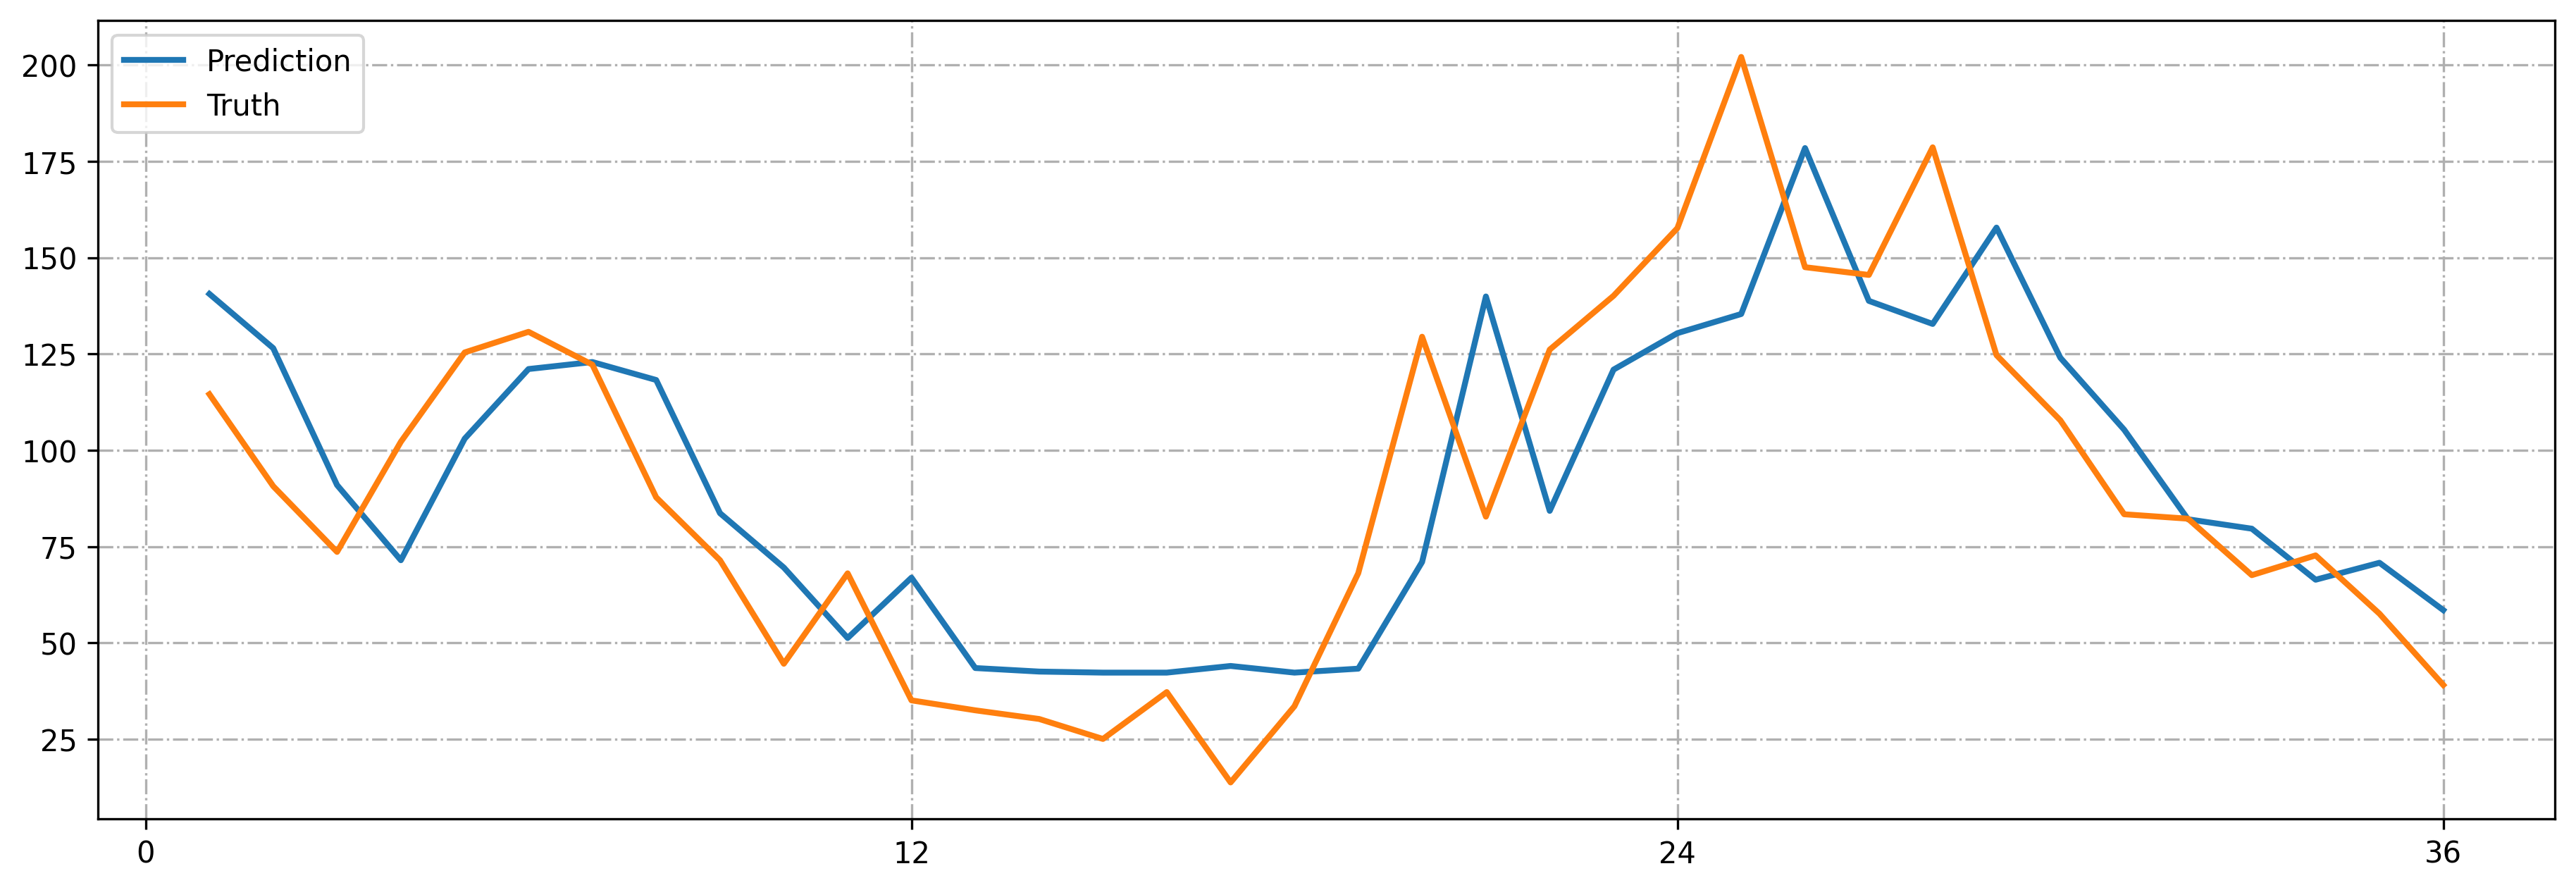

In [12]:
# plot 
fig, ax = pyplot.subplots(figsize=(15,5), dpi = 300)
ax.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linewidth=2.0, label = "Prediction")
ax.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(12)
ax=pyplot.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
pyplot.grid(linestyle='-.')
pyplot.show()

In [13]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
MAE = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' %MAE)

Test RMSE: 28.220
Test MAE: 23.464
